<a href="https://colab.research.google.com/github/Steriva/MfM_Assignment/blob/main/exe02d_NN_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [72]:
reset-f

### Loading packages

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm 
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split


from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from scipy.integrate import odeint
from google.colab import files

import tqdm.notebook
# import tqdm.tqdm (uncomment this when executing as a .py)

rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Neural Network for the Lorenz equation
At first let us present the Lorenz equations
\begin{equation}
\left\{
\begin{split}
\frac{\partial x}{\partial t} &= \sigma(y-x)\\
\frac{\partial y}{\partial t} &= x\cdot (\rho-z)-y\\
\frac{\partial z}{\partial t} &= x\cdot y - \beta \, z
\end{split}
\right.
\end{equation}
given $[0, T]$ the time domain. 

The parameters are equal to
\begin{equation}
\sigma = 10\qquad \beta = \frac{8}{3}\qquad \rho = [10, 28, 35]^T
\end{equation}

The system of equations is solved considering 100 different IC, randomly generated in $[-15, 15]$.

The input/output training data are stored in a matrix solution, whose dimensions are 
\begin{equation}
100\cdot \left[\mbox{len}(t)-1\right]\cdot \left[\mbox{len}(\rho)\right]\times 3
\end{equation}

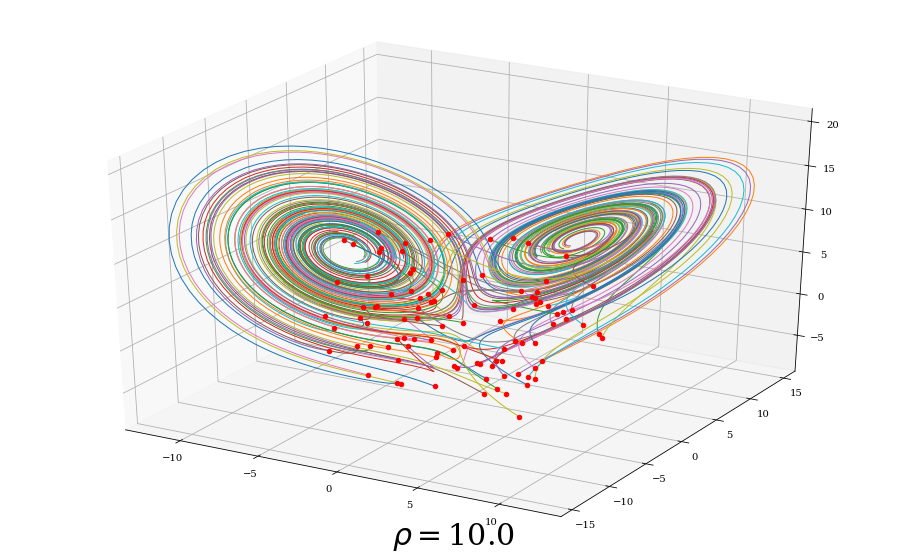

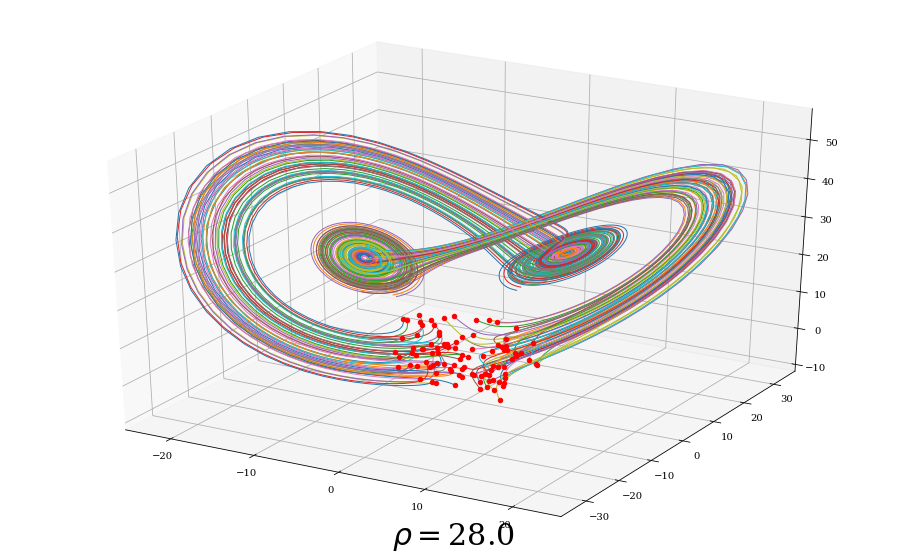

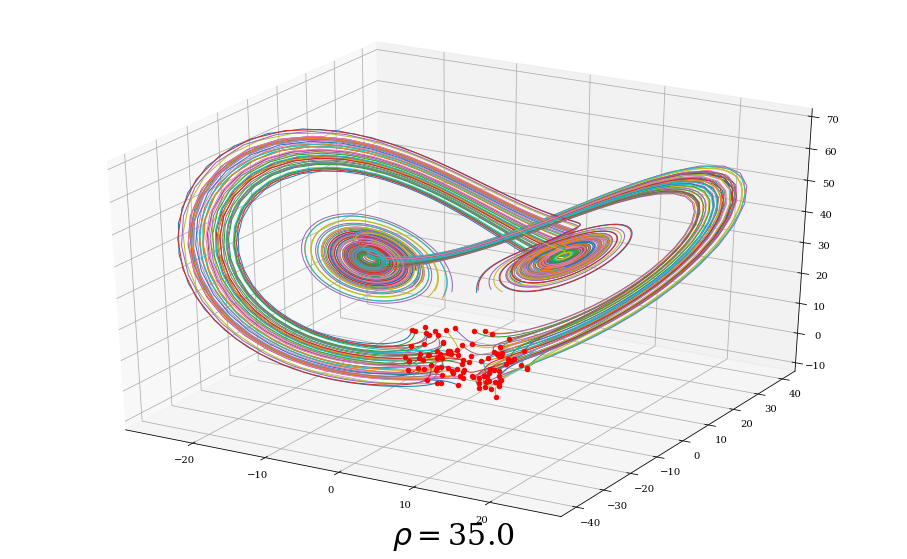

In [76]:
## Generating the Lorenz System training data

dt = 0.01 # to lower computational cost
T = 2
t = np.arange(0, T+dt, dt)

# Lower and Upper Bound for IC
lb = -7.5
ub =  7.5

beta = 8/3
sigma = 10
rhoVec = np.array([10., 28., 35.])

numTraj = 100

nn_input = np.zeros((numTraj *(len(t)-1) * len(rhoVec),3))
nn_output = np.zeros_like(nn_input)

np.random.seed(123)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

for rho_j in range(len(rhoVec)):
  rho = rhoVec[rho_j]
  ax = plt.figure().add_subplot(projection='3d')

  def lorenz_deriv(x_y_z, t0, rho=rho, sigma=sigma, beta=beta):
      x, y, z = x_y_z
      return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

  x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                    for x0_j in x0])
  for j in range(numTraj):
    nn_input[j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    plt.title( r'$\rho = $' + str(rho), fontsize = 30 )

## Training the Neural Network


Let's build the model at first with 2 layers (the input and output with linear activation function are not counted), with 5 neurons each. 'relu' activation function is adopted.

The loss function is the Mean Square Error (MSE) and the optimizer is 'adam'.

In [77]:
NN_model = keras.models.Sequential()

NN_model.add(layers.Dense(40, input_dim = 3, activation='sigmoid', name='Input')) # input layer
NN_model.add(layers.Dense(40, activation='relu'))
NN_model.add(layers.Dense(40, activation='relu'))
NN_model.add(layers.Dense(3,  activation='linear'))

NN_model.compile( loss='mse', 
                  optimizer=keras.optimizers.Adam(learning_rate = 5e-4) )

Now, we can train out net with 1000 epochs.

In [ ]:
History = NN_model.fit(nn_input, nn_output, epochs=600, batch_size = 32 )

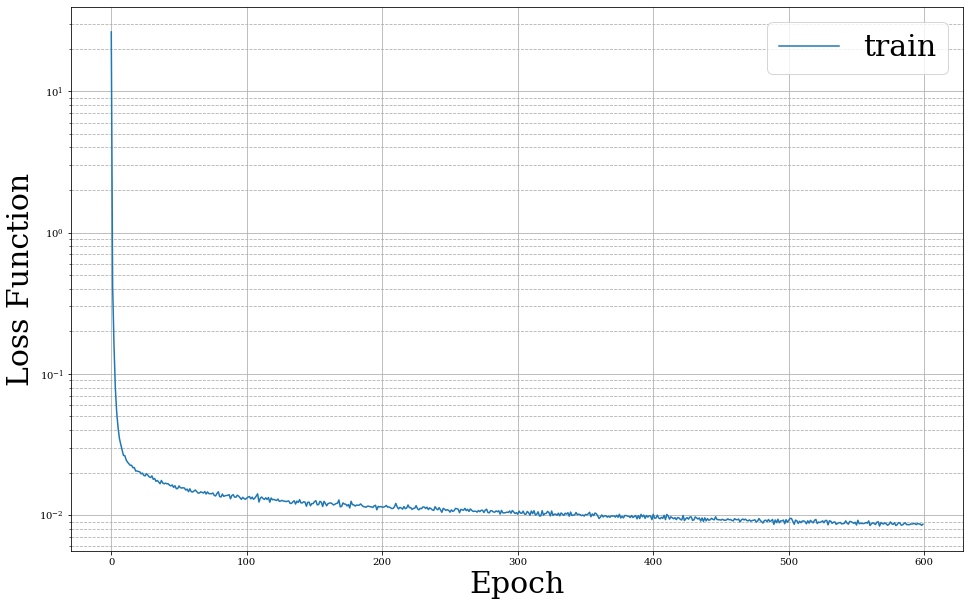

In [79]:
plt.figure()
plt.semilogy(History.history['loss'])
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.ylabel('Loss Function',fontsize=30)
plt.xlabel('Epoch',fontsize=30)
plt.legend(['train', 'test'], loc='upper right',fontsize=30)
plt.show()

The trained model will be saved for later use

In [80]:
# serialize model to JSON
model_json = NN_model.to_json()
with open("LorenzNNmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
NN_model.save_weights("LorenzNNmodel.h5")

files.download("LorenzNNmodel.json")
files.download("LorenzNNmodel.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading the model, to check everything went well

In [81]:
# load json and create model
json_file = open('LorenzNNmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
NN_model = model_from_json(loaded_model_json)
# load weights into new model
NN_model.load_weights("LorenzNNmodel.h5")
NN_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 40)                160       
                                                                 
 dense_31 (Dense)            (None, 40)                1640      
                                                                 
 dense_32 (Dense)            (None, 40)                1640      
                                                                 
 dense_33 (Dense)            (None, 3)                 123       
                                                                 
Total params: 3,563
Trainable params: 3,563
Non-trainable params: 0
_________________________________________________________________


# Check training
Let us consider $\rho= 28$ and let's see how the prediction of NNs is with respect to the ODE-solution.

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

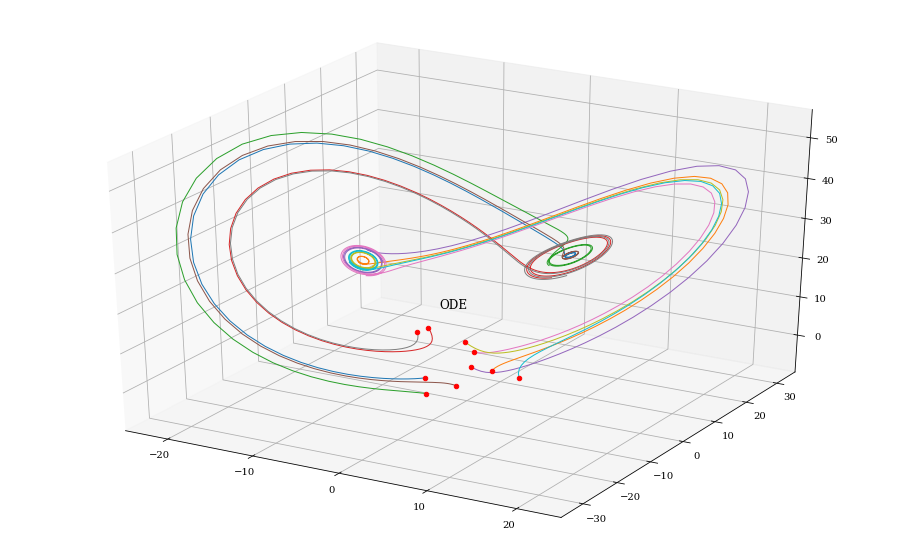

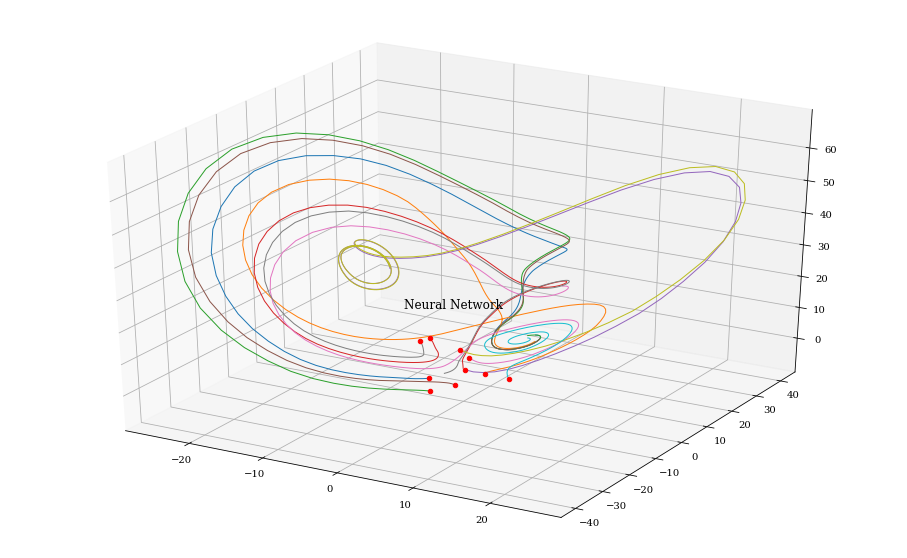

In [82]:
rhoInterp = 28

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

InterpNN = np.zeros_like(x_t)

InterpNN[:,0,:] = x0[:]


## ODE plot
ax = plt.figure().add_subplot(projection='3d')

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  ax.plot(xInterp, yInterp, zInterp,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE')
  
## NN plot
ax = plt.figure().add_subplot(projection='3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 3])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network')
  progressBar.update(1)

# Interpolation
Let us consider $\rho= 17$ and let's see how the prediction of NNs is with respect to the ODE-solution

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

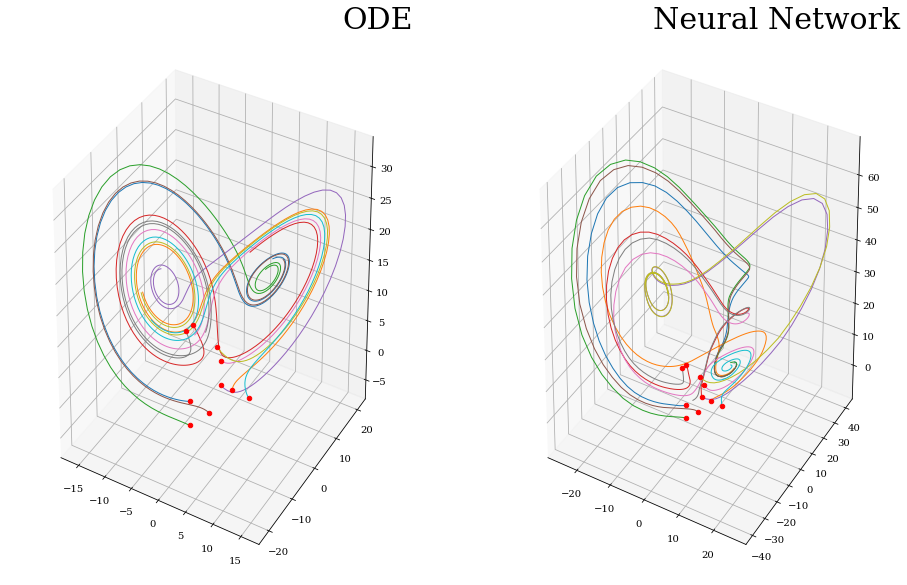

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
rhoInterp = 17

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

InterpNN = np.zeros_like(x_t)

InterpNN[:,0,:] = x0[:]


## ODE plot
figInt = plt.figure()
ax = figInt.add_subplot(1,2,1, projection = '3d')

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  ax.plot(xInterp, yInterp, zInterp,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE', fontsize = 30, loc='right')
  
## NN plot
ax = figInt.add_subplot(1,2,2, projection = '3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 3])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network', fontsize = 30, loc='right')
  progressBar.update(1)

plt.show()

figInt.savefig('NN_LorenzInterpolation.pdf', format='pdf', dpi=600, bbox_inches='tight')

files.download('NN_LorenzInterpolation.pdf')

# Extrapolation
Let us consider $\rho= 40$ and let's see how the prediction of NNs is with respect to the ODE-solution

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

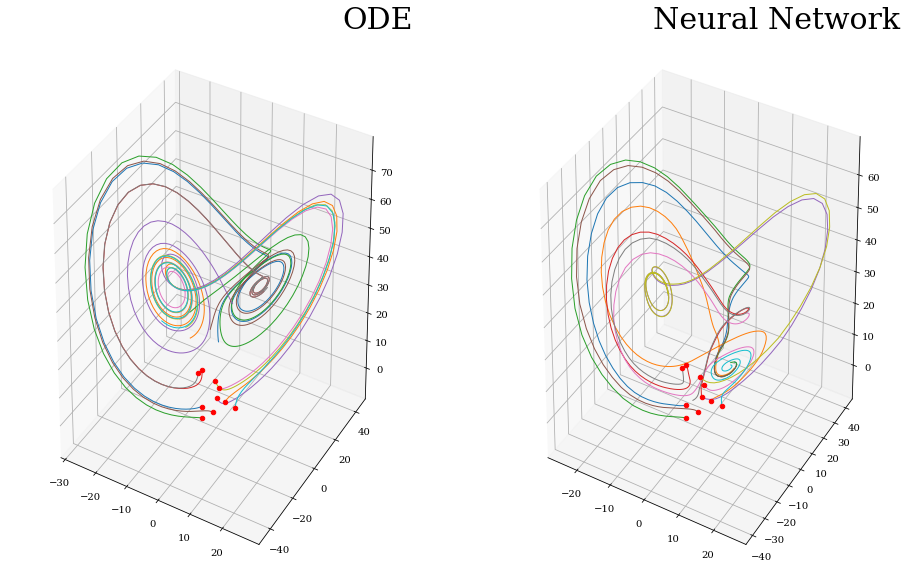

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
rhoExtrap = 40

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoExtrap, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

InterpNN = np.zeros_like(x_t)

InterpNN[:,0,:] = x0[:]


## ODE plot
figExtrp = plt.figure()
ax = figExtrp.add_subplot(1,2,1, projection = '3d')

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  ax.plot(xInterp, yInterp, zInterp,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE', fontsize = 30, loc='right')
  
## NN plot
ax = figExtrp.add_subplot(1,2,2, projection = '3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 3])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network', fontsize = 30, loc='right')
  progressBar.update(1)

plt.show()

figExtrp.savefig('NN_LorenzExtrapolation.pdf', format='pdf', dpi=600, bbox_inches='tight')

files.download('NN_LorenzExtrapolation.pdf')